In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')


In [2]:
import pymc3 as pm, theano.tensor as tt

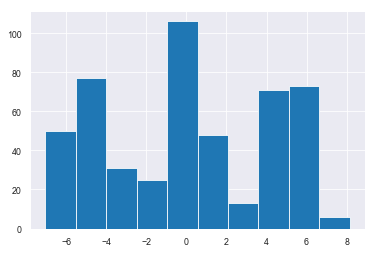

In [3]:
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [5]:
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [7]:
with model:    
    tr = pm.sample(10000, chains=4)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [sd, means, p]
>CategoricalGibbsMetropolis: [category]
Sampling 4 chains: 100%|██████████| 42000/42000 [26:50<00:00, 14.25draws/s] 
The acceptance probability does not match the target. It is 0.9248406517430061, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9162843648173226, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.91929997096573, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9124203223223629, but should be close to 0.8. Try to increase the number of tuning steps.


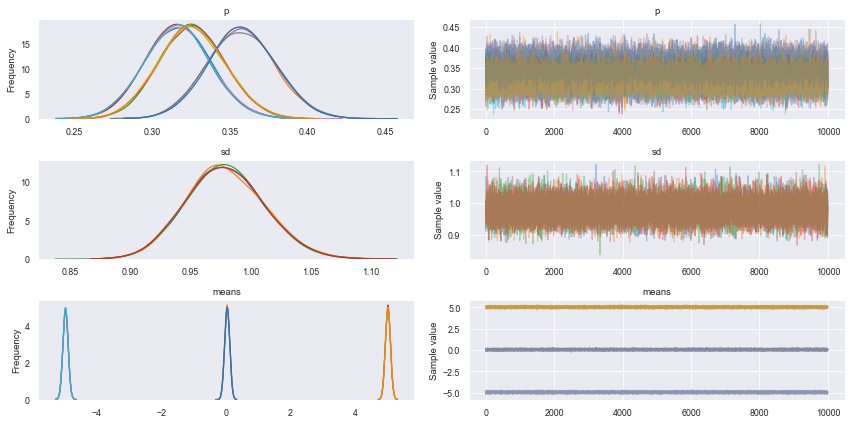

In [8]:
pm.plots.traceplot(tr, ['p', 'sd', 'means']);

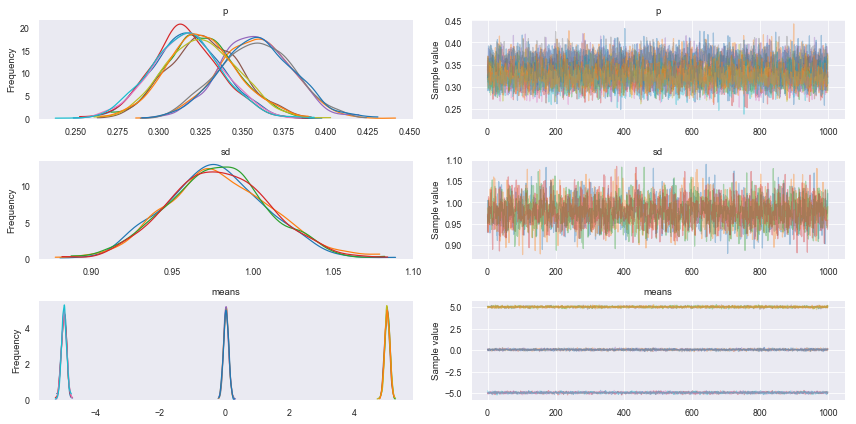

In [9]:

# take a look at traceplot for some model parameters
# (with some burn-in and thinning)
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means']);



In [11]:
import arviz as az

In [13]:
az.effective_sample_size(tr)

<xarray.Dataset>
Dimensions:         (category_dim_0: 500, means_dim_0: 3, p_dim_0: 3)
Coordinates:
  * means_dim_0     (means_dim_0) int64 0 1 2
  * category_dim_0  (category_dim_0) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * p_dim_0         (p_dim_0) int64 0 1 2
Data variables:
    means           (means_dim_0) float64 4.956e+04 4.121e+04 4.801e+04
    category        (category_dim_0) float64 1.27e+04 nan nan ... 1.318e+04 nan
    p               (p_dim_0) float64 5.276e+04 5.203e+04 5.739e+04
    sd              float64 3.936e+04

In [14]:
az.rhat(tr)

<xarray.Dataset>
Dimensions:         (category_dim_0: 500, means_dim_0: 3, p_dim_0: 3)
Coordinates:
  * means_dim_0     (means_dim_0) int64 0 1 2
  * category_dim_0  (category_dim_0) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * p_dim_0         (p_dim_0) int64 0 1 2
Data variables:
    means           (means_dim_0) float64 1.0 1.0 1.0
    category        (category_dim_0) float64 1.0 nan nan nan ... nan 1.0 1.0 nan
    p               (p_dim_0) float64 1.0 1.0 1.0
    sd              float64 1.0